In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

import torch
import torch.distributions as dist

import matplotlib.pyplot as plt
import matplotlib.style as style
# style.use('https://raw.githubusercontent.com/ad3ller/pub_mplstyle/master/pub.mplstyle')
%matplotlib inline

style.use('../mpl_stylesheet.mplstyle')

In [3]:
from geobed.continuous.core import BED_Class

/home/dstrutz/sshfs/Libs/GeoBED/geobed/continuous/core.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from avo_sleipnir_parameters import nuisance_parameter_table, nuisance_dist, name_to_index

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [5]:
display(nuisance_parameter_table.T)

,mean,std
$\alpha_1$,2.270000e+03,1.000000e+01
$\beta_1$,8.540000e+02,1.000000e+01
$\rho_1$,2.100000e+03,1.000000e+01
$d$,1.000000e+03,5.000000e+01
$K_{grain}$,3.930000e+10,1.414800e+09
$\rho_{grain}$,2.664000e+03,2.664000e+00
$K_{frame}$,2.560000e+09,7.680000e+07
$G_{frame}$,8.500000e+09,2.550000e+08
$\phi$,3.700000e-01,2.497500e-02
$K_{brine}$,2.350000e+09,7.614000e+07


In [6]:
# prior parameter
co2_saturations_min = torch.tensor([0.0])
co2_saturations_max = torch.tensor([1.0])
co2_saturations_prior_dist = dist.Independent(dist.Uniform(co2_saturations_min, co2_saturations_max),1)

In [7]:
# nuisance distribution

def nuisance_dist_func(model_samples):
    return nuisance_dist

In [8]:
def co2_to_seismic(co2_samples, nuisance_samples):
        
    co2_samples = co2_samples.unsqueeze(-1)

    K_dry_nuisance_samples = nuisance_samples[..., name_to_index['K_frame']]
    G_dry_nuisance_samples = nuisance_samples[..., name_to_index['G_frame']]
    K_grain_nuisance_samples = nuisance_samples[..., name_to_index['K_grain']]
    rho_grain_nuisance_samples = nuisance_samples[..., name_to_index['rho_grain']]
    K_brine_nuisance_samples = nuisance_samples[..., name_to_index['K_brine']]
    rho_brine_nuisance_samples = nuisance_samples[...,name_to_index['rho_brine']]
    K_co2_nuisance_samples = nuisance_samples[..., name_to_index['K_co2']]
    rho_co2_nuisance_samples = nuisance_samples[..., name_to_index['rho_co2']]
    porosity_nuisance_samples = nuisance_samples[..., name_to_index['porosity']]
    
    water_saturation = 1.0 - co2_samples
    
    K_f_nuisance_samples = K_brine_nuisance_samples*water_saturation[:, 0] + K_co2_nuisance_samples*co2_samples[:, 0]
    rho_f_nuisance_samples = rho_brine_nuisance_samples*water_saturation[:, 0] + rho_co2_nuisance_samples*co2_samples[:, 0]

    # the implementation of the gassman equation is taken from the bruges library: https://github.com/agilescientific/bruges/blob/main/bruges/rockphysics/fluidsub.py
    
    rho_2 = rho_grain_nuisance_samples * (1 - porosity_nuisance_samples) + rho_f_nuisance_samples * porosity_nuisance_samples
    K = K_dry_nuisance_samples + (1 - K_dry_nuisance_samples / K_grain_nuisance_samples)**2 / ( (porosity_nuisance_samples / K_f_nuisance_samples)
        + ((1 - porosity_nuisance_samples) / K_grain_nuisance_samples) - (K_dry_nuisance_samples / K_grain_nuisance_samples**2) )
    
    vp_2 = torch.sqrt((K + 4/3 * G_dry_nuisance_samples) / rho_2)
    vs_2 = torch.sqrt(G_dry_nuisance_samples / rho_2)
    
    return vp_2, vs_2, rho_2

test_model_samples torch.Size([10000, 1])
test_nuisance_samples torch.Size([10000, 1, 13])
test_seismic_2_parameters torch.Size([10000, 1])


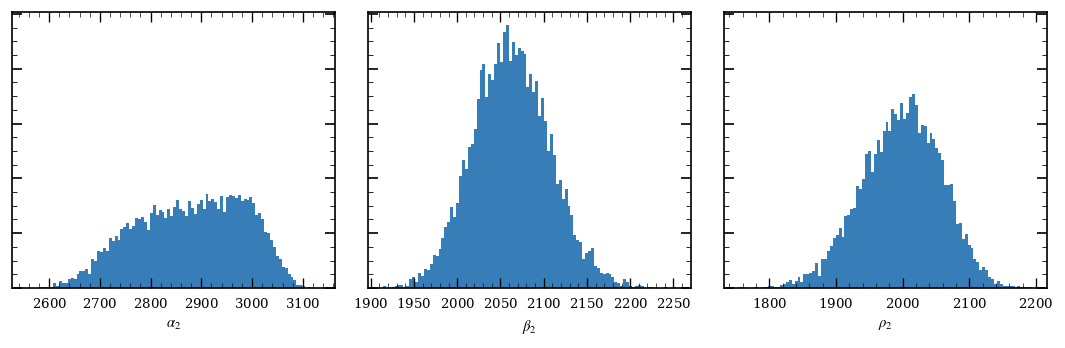

In [9]:
# test

n_test = 10000

test_model_samples = co2_saturations_prior_dist.sample((n_test,))
test_nuisance_samples = nuisance_dist.sample((n_test,1))

print('test_model_samples', test_model_samples.shape)
print('test_nuisance_samples', test_nuisance_samples.shape)

test_seismic_2_parameters = co2_to_seismic(test_model_samples, test_nuisance_samples)

print('test_seismic_2_parameters', test_seismic_2_parameters[0].shape)

fig, ax = plt.subplots(1,3, figsize=(9,3), sharey=True,)

ax[0].hist(test_seismic_2_parameters[0][:,0], bins=100, density=True, label='a_2')
ax[1].hist(test_seismic_2_parameters[1][:,0], bins=100, density=True, label='b_2')
ax[2].hist(test_seismic_2_parameters[2][:,0], bins=100, density=True, label='rho_2')

ax[0].set_xlabel(r'$\alpha_2$')
ax[1].set_xlabel(r'$\beta_2$')
ax[2].set_xlabel(r'$\rho_2$')

for a in ax:
    a.set_yticklabels([])

plt.tight_layout()
plt.show()


In [10]:
from geobed.fwd_collection.avo import zoeppritz_solver_rpp

def seismic_to_Rp(offset, params):

    offset = offset
    params = params.swapaxes(0,-1)
    
    theta_1 = torch.atan( offset / (2 * params[0]) )
        
    return zoeppritz_solver_rpp(theta_1, params[1], params[2], params[3], params[4], params[5], params[6])


In [11]:
def forward_function(design, model_samples, nuisance_samples):
    
    
    print(model_samples.shape)
    
    vp_2, vs_2, rho_2 = co2_to_seismic(model_samples, nuisance_samples)
    
    d = nuisance_samples[..., name_to_index['d']]
    vp_1 = nuisance_samples[..., name_to_index['alpha_1']]
    vs_1 = nuisance_samples[..., name_to_index['beta_1']]
    rho_1 = nuisance_samples[..., name_to_index['rho_1']]

    R_p = seismic_to_Rp(design[:, None, None, None], torch.stack([d, vp_1, vp_2, vs_1, vs_2, rho_1, rho_2], dim=-1)[None, ...]).permute(1,2,0,3).squeeze(-1)
        
    return R_p
    

In [12]:
def data_likelihood_avo(samples, design=None, ):    
    std_data = 0.05
    data_likelihood = dist.Independent(dist.Normal(samples, torch.tensor(std_data)), 1)
    
    return data_likelihood

In [13]:
n_designs = 200
design_list = torch.linspace(100, 5000, n_designs).unsqueeze(-1)

Test_BED_Class = BED_Class(
    forward_function=forward_function,
    obs_noise_dist=data_likelihood_avo,
    m_prior_dist=co2_saturations_prior_dist,
    # m_prior_samples=,
    nuisance_dist=nuisance_dist,
    # nuisance_parameter_samples=nuisance_parameter_samples,
    )

In [14]:
n_visual_model_samples = int(1e3)
n_visual_nuisance_samples = int(1e1)

# R_p_test = forward_function(
#     designs.squeeze(), test_model_samples, test_nuisance_samples)

clean_data = Test_BED_Class.get_forward_function_samples(
    design_list.squeeze(),
    n_samples_model=n_visual_model_samples,
    n_samples_nuisance=n_visual_nuisance_samples,
    random_seed_model=1,
    random_seed_nuisance=2,
    )

noisy_data = Test_BED_Class.get_forward_model_samples(
    design_list.squeeze(),
    n_samples_model=n_visual_model_samples,
    n_samples_nuisance=n_visual_nuisance_samples,
    random_seed_model=1,
    random_seed_nuisance=2,
    )

torch.Size([1000, 1])
torch.Size([1000, 1])


In [15]:
clean_data.shape

torch.Size([1000, 10, 200])

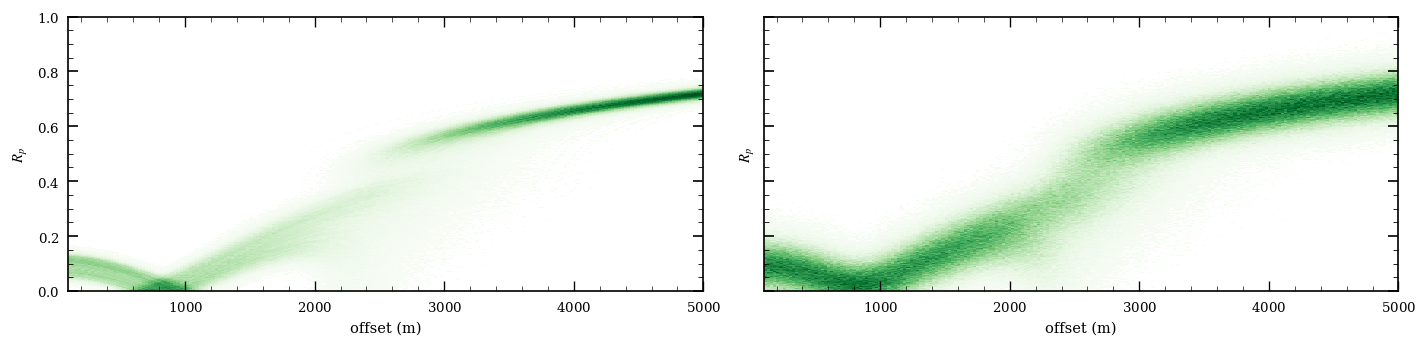

In [16]:
fig = plt.figure(figsize=(12, 3))
ax_dict = fig.subplot_mosaic(
    '''ab''',
    # gridspec_kw={'wspace': 0.2},
    sharex=True, sharey=True)

ax_dict['a'].hist2d(design_list.squeeze().expand(n_visual_model_samples*n_visual_nuisance_samples, -1).flatten().numpy(),
                    clean_data.squeeze().flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(design_list.squeeze().expand(n_visual_model_samples*n_visual_nuisance_samples, -1).flatten().numpy(),
                    noisy_data.squeeze().flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)

for a in ax_dict.values():
    a.set_xlim([100, 5000])
    a.set_ylim([0, 1])
    a.set_xlabel('offset (m)')
    a.set_ylabel(r'$R_p$')

plt.tight_layout()

plt.show()

In [17]:
num_workers = 1

INFO:root:Loading results from data/avo_test_nuisance_varpost.pkl


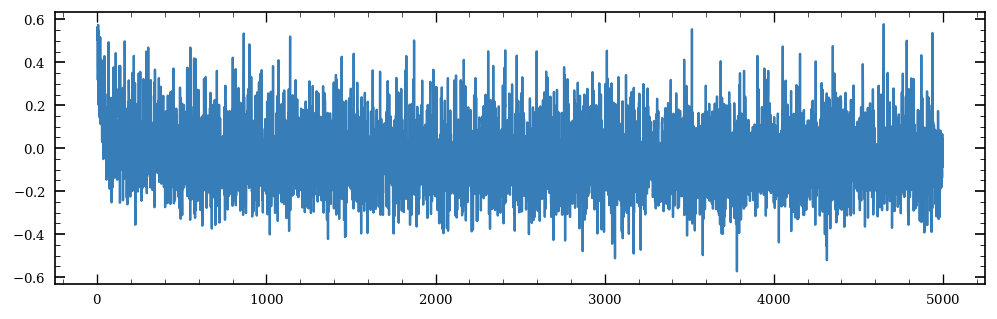

In [18]:
from geobed.discrete.guides import MDN_guide

T = int(1e4)
N = T//2
M = T//2
n_batch = 10
n_epochs = 10

scheduler = torch.optim.lr_scheduler.ExponentialLR
max_lr = 1e-4
min_lr = 1e-6
gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

eig_varpost, out_varpost = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='variational_posterior',
    eig_method_kwargs=
        {'guide': MDN_guide,
        'N': N,
        'M': M,
        'guide_kwargs': {'components':5, 'hidden_features':[50, 50, 50], 'normalize':True},
        'n_batch': n_batch,
        'n_epochs': n_epochs,
        # 'optimizer': None,
        'optimizer_kwargs': {'lr': max_lr},
        'scheduler': scheduler,
        'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
        'return_guide': True,
        'return_train_loss': True,
        'return_test_loss': True,
        },
    num_workers=num_workers,
    parallel_library='joblib',
    random_seed=1,
    filename='data/avo_test_nuisance_varpost.pkl',
)

plt.figure(figsize=(10, 3))
plt.plot(out_varpost[0]['train_loss'], label='train loss')
plt.show()

In [19]:
T  = int(1e6)
# dependent nuisance parameters
M_prime = 100
T_evidence = T//M_prime

N = T_evidence//2
M = T_evidence//2

print(f'N={N}, M={M}, M_prime={M_prime}')

Test_BED_Class.independent_nuisance_parameters = False

eig_nmc, out_nmc = Test_BED_Class.calculate_EIG(
    # design=design_list[:1],
    design=design_list,
    eig_method='NMC',
    eig_method_kwargs={'N': N, 'M': M, 'M_prime': M_prime,
                       'reuse_M':True, 'memory_efficient':True
                       },
    num_workers=num_workers,
    parallel_library='joblib',
    random_seed=1,
    filename='data/avo_test_nuisance_nmc.pkl',
)

INFO:root:Loading results from data/avo_test_nuisance_nmc.pkl


N=5000, M=5000, M_prime=100


In [20]:
from geobed.discrete.guides import MDN_guide
from geobed.discrete.guides import GMM_guide

T = int(1e4)
N = T//2
M = T//2
n_batch = 10
n_epochs = 10

scheduler = torch.optim.lr_scheduler.ExponentialLR
max_lr = 1e-2
min_lr = 1e-6
gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

eig_varmarglike, out_varmarglike = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='variational_marginal_likelihood',
    eig_method_kwargs=
        {'N': N,
         'M': M,
         'marginal_guide': GMM_guide,
         'marginal_guide_kwargs': {'components':5, 'init_method': {'init_params': 'k-means++', 'n_init': 10, 'max_iter': 1}},
         'conditional_guide': MDN_guide,
         'conditional_guide_kwargs': {'components':10, 'hidden_features':[50, 50, 50], 'normalize':True},
         'n_batch': n_batch,
         'n_epochs': n_epochs,
        #  'optimizer': None,
         'optimizer_kwargs': {'lr': max_lr},
         'scheduler': scheduler,
         'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
         'return_guide': True,
         'return_train_loss': True,
         'return_test_loss': True,
        },
    num_workers=num_workers,
    parallel_library='joblib',
    random_seed=1,
    filename='data/avo_test_nuisance_varmarglike.pkl',
)

plt.figure(figsize=(10, 3))
plt.plot(out_varmarglike[0]['train_loss'], label='train loss')
plt.show()

INFO:root:File data/avo_test_nuisance_varmarglike.pkl does not exist. Calculating results.


Calculating eig:   0%|          | 0/200 [00:00<?, ?it/s]

TypeError: BED_Class.__init__.<locals>.Dummy_Foward_Class.forward() got an unexpected keyword argument 'squeeze_nuisance'

INFO:root:Loading results from data/avo_test_nuisance_flo.pkl


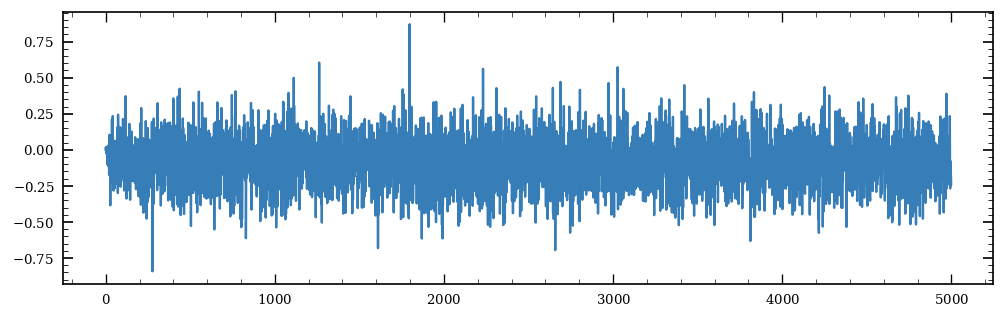

In [ ]:
from geobed.discrete.guides import MLP_FLO

T = int(1e4)
N = T//2
M = T//2
n_batch = 10
n_epochs = 10

scheduler = torch.optim.lr_scheduler.ExponentialLR
max_lr = 1e-4
min_lr = 1e-5
gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

eig_flo, out_flo = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='FLO',
    eig_method_kwargs=
        {'guide': MLP_FLO,
        'N': N,
        'M': M,
        'K': 'adaptive',
        'guide_kwargs': {'H':[100, 100, 100, 100,],},
        'guide_kwargs': {'H':[100, 100,],},
        'n_batch': n_batch,
        'n_epochs': n_epochs,
        # 'optimizer': None,
        'optimizer_kwargs': {'lr': max_lr},
        'scheduler': scheduler,
        'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
        'return_guide': True,
        'return_train_loss': True,
        'return_test_loss': True,
        },
    num_workers=num_workers,
    parallel_library='joblib',
    random_seed=1,
    filename='data/avo_test_nuisance_flo.pkl',
)

plt.figure(figsize=(10, 3))
plt.plot(out_flo[0]['train_loss'], label='train loss')
plt.show()

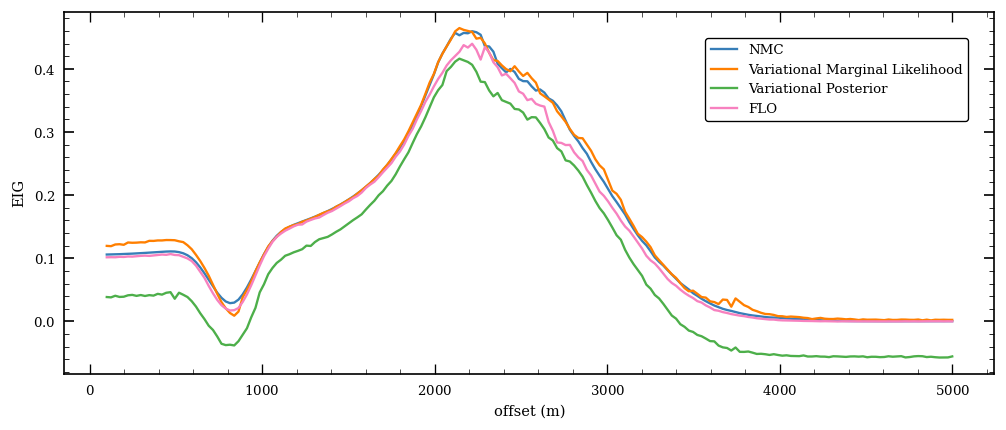

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(design_list, eig_nmc, label=r'NMC')
# ax.plot(design_list, eig_dn, label=r'$D_{N}$')
ax.plot(design_list, eig_varmarglike.detach(), label=r'Variational Marginal Likelihood')
ax.plot(design_list, eig_varpost, label=r'Variational Posterior')
ax.plot(design_list, eig_flo, label=r'FLO')

ax.set_xlabel('offset (m)')
ax.set_ylabel('EIG')

ax.legend()
# ax.grid()

plt.show()